# Recurrent Neural Networks and Bitcoins

### Marco Tavora

## Introduction

Nowadays most articles about bitcoin are speculative. Analyses based on strong technical foundations are rare.

My goal in this project is to build predictive models for the price of Bitcoins and other cryptocurrencies. To accomplish that, I will:
- Use first Long Short-Term Memory recurrent neural networks (LSTMs) for predictions;
- I will then study correlations between altcoins;
- The third step will be to repeat the first analysis using traditional time series.

For a thorough introduction to Bitcoins you can check this [book](https://github.com/bitcoinbook/bitcoinbook). For LSTM [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a great source.

## Importing libraries

In [61]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import aux_functions as af 
from scipy import stats
import keras
import pickle
import quandl
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras import initializers
import datetime
from datetime import datetime
from matplotlib import pyplot as plt
import json
import requests
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # see the value of multiple statements at once.
pd.set_option('display.max_columns', None)

## Data

There are several ways to fetch historical data for Bitcoins (or any other cryptocurrency). Here are a few examples:

###  Flat files
If a flat file already available, we can just read it using `pandas`. For example, one of the datasets that will be used in this notebook can be found [here](https://www.kaggle.com/mczielinski/bitcoin-historical-data/data). This data is from *bitFlyer* a Bitcoin exchange and marketplace.

In [3]:
df = pd.read_csv('bitcoin_data.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1499155260,296127,296558,296016,296540,1.158600,3.432441e+05,296257.67168
1,1499155320,296539,296769,296060,296679,11.115510,3.295332e+06,296462.51372
2,1499155380,296060,296090,296060,296060,5.527494,1.636491e+06,296063.83615
3,1499155440,296060,296260,296015,296015,8.414064,2.491620e+06,296125.66780
4,1499155500,296361,296540,296155,296155,3.993010,1.183292e+06,296340.78573


This dataset from [Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data/kernels) contains, for the time period of 01/2012-03/2018, minute-to-minute updates of the open, high, low and close prices (OHLC), the volume in BTC and indicated currency, and the [weighted bitcoin price](https://github.com/Bitcoin-Foundation-Italia/bitcoin-wp). 

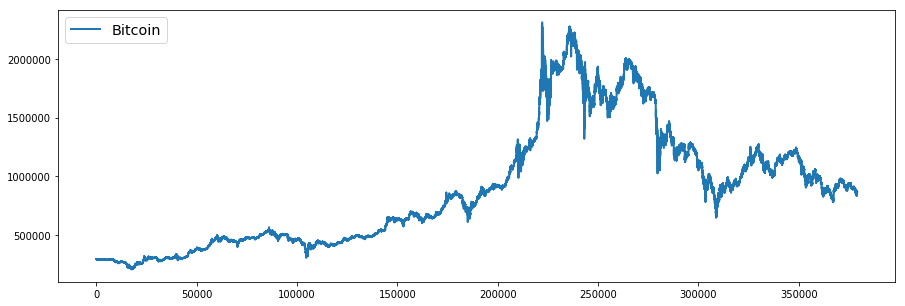

In [4]:
lst_col = df.shape[1]-1
df.iloc[:,lst_col].plot(lw=2, figsize=(15,5));
plt.legend(['Bitcoin'], loc='upper left',fontsize = 'x-large');

###  Retrieve Data from Quandl's API
Another possibility is to retrieve Bitcoin pricing data using Quandl's free [Bitcoin API](https://blog.quandl.com/api-for-bitcoin-data). For example, to obtain the daily bitcoin exchange rate (BTC vs. USD) on Bitstamp (Bitstamp is a bitcoin exchange based in Luxembourg) we use the code snippet below. The function `quandl_data` is inside the library `af`.

In [5]:
quandl_id = 'BCHARTS/KRAKENUSD'
df_qdl = af.quandl_data(quandl_id)
df_qdl.columns = [c.lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df_qdl.columns.values]
df_qdl.head()

Loaded BCHARTS/KRAKENUSD from cache


,open,high,low,close,volume_btc,volume_currency,weighted_price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


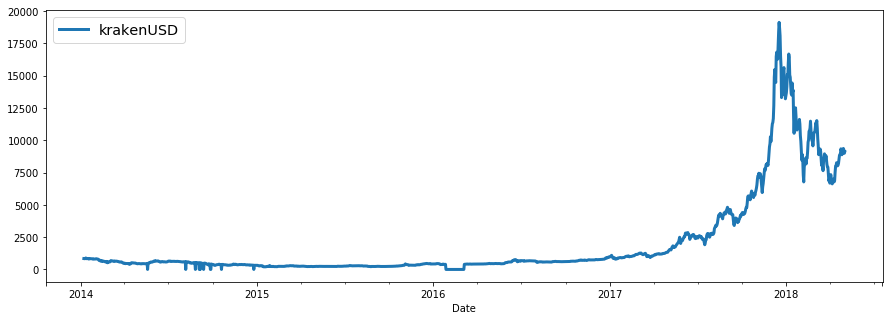

In [6]:
lst_col_2 = df_qdl.shape[1]-1
df_qdl.iloc[:,lst_col_2].plot(lw=3, figsize=(15,5));
plt.legend(['krakenUSD'], loc='upper left',fontsize = 'x-large');

### Retrieve Data from cryptocompare.com
Another possibility is to retrieve data from [cryptocompare](https://www.cryptocompare.com/). In this case, we use the `requests` packages to make a `.get` request (the object `res` is a `Response` object) such as:

    res = requests.get(URL)

In [7]:
res = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
df_cc = pd.DataFrame(json.loads(res.content)['Data']).set_index('time')
df_cc.index = pd.to_datetime(df_cc.index, unit='s')
df_cc.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2012-11-22,12.42,12.43,11.67,11.77,58301.30,703582.88
2012-11-23,12.35,12.41,12.13,12.42,18967.90,233370.93
2012-11-24,12.41,12.48,12.25,12.35,19570.39,242058.59
2012-11-25,12.48,12.60,12.31,12.41,24023.69,299989.40
2012-11-26,12.25,12.65,11.89,12.48,35913.82,443753.07


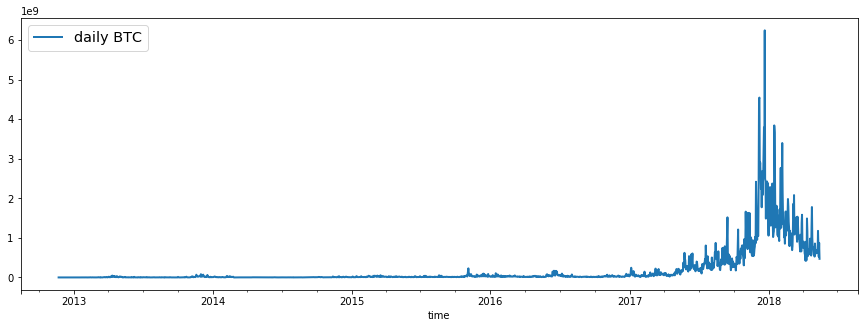

In [8]:
lst_col = df_cc.shape[1]-1
df_cc.iloc[:,lst_col].plot(lw=2, figsize=(15,5));
plt.legend(['daily BTC'], loc='upper left',fontsize = 'x-large');

## Data Handling

Let us start with `df` (from *bitFlyer*) from Kaggle.

### Checking for `NaNs` and  making column titles cleaner

Using `df.isnull().any()` we quickly see that the data does not contain null values. We get rid of upper cases, spaces, parentheses and so on, in the column titles.

In [9]:
df.isnull().sum()
df.columns = [c.lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns.values]
df.head()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

,timestamp,open,high,low,close,volume_btc,volume_currency,weighted_price
0,1499155260,296127,296558,296016,296540,1.158600,3.432441e+05,296257.67168
1,1499155320,296539,296769,296060,296679,11.115510,3.295332e+06,296462.51372
2,1499155380,296060,296090,296060,296060,5.527494,1.636491e+06,296063.83615
3,1499155440,296060,296260,296015,296015,8.414064,2.491620e+06,296125.66780
4,1499155500,296361,296540,296155,296155,3.993010,1.183292e+06,296340.78573


### Group data by day and take the mean value


Though Timestamps are in Unix time, this is easily taken care of using Python's `datetime` library:
- `pd.to_datetime` converts the argument to `datetime` 
- `Series.dt.date` gives a numpy array of Python `datetime.date` objects

We then drop the `Timestamp` column. The repeated dates occur simply because the data is collected minute-to-minute. Taking the daily mean using the method `daily_weighted_prices` from `af` we obtain:

In [10]:
daily = af.daily_weighted_prices(df,'date','timestamp','s')
daily.head()

date
2017-07-04    292177.556681
2017-07-05    290562.675337
2017-07-06    293182.524481
2017-07-07    289683.612931
2017-07-08    289174.397839
Name: weighted_price, dtype: float64

## Exploratory Data Analysis

We can look for trends and seasonality in the data. Joining train and test sets and using the functions `trend`, `seasonal`, `residue` and `plot_components` for `af`:

### Trend, seasonality and residue

In [11]:
dataset = daily.reset_index()
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.set_index('date')

af.plot_comp(af.trend(dataset,'weighted_price'),
          af.seasonal(dataset,'weighted_price'),
          af.residue(dataset,'weighted_price'),
          af.actual(dataset,'weighted_price'))              

# Partial Auto-correlation (PACF)

The PACF is the correlation (of the variable with itself) at a given lag, **controlling for the effect of previous (shorter) lags**. We see below that according to the PACF, prices with **one day** difference are highly correlated. After that the partial auto-correlation essentially drops to zero.

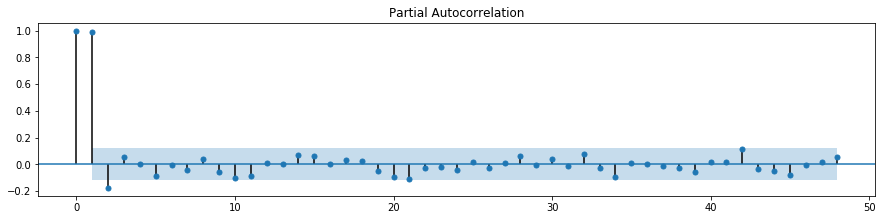

In [12]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_pacf(dataset['weighted_price'].values.squeeze(), lags=48, ax=ax)
plt.show();

## Train/Test split

We now need to split our dataset. We need to fit the model using the training data and test the model with the test data. We can proceed as follows. We must choose the proportion of rows that will constitute the training set.

In [13]:
train_size = 0.75
training_rows = train_size*len(daily)
int(training_rows)

198

Then we slice `daily` using, for obvious reasons:

        [:int(training_rows)]
        [int(training_rows):]
        
We then have:

In [14]:
train = daily[0:int(training_rows)]  
test = daily[int(training_rows):] 
print('Shapes of training and testing sets:',train.shape[0],'and',test.shape[0])

Shapes of training and testing sets: 198 and 67


We can automatize the split using a simple function for the library `aux_func`:

In [15]:
test_size = 1 - train_size
train = af.train_test_split(daily, test_size=test_size)[0]
test = af.train_test_split(daily, test_size=test_size)[1]
print('Shapes of training and testing sets:',train.shape[0],'and',test.shape[0])
af.vc_to_df(train).head() 
af.vc_to_df(train).tail() 
af.vc_to_df(test).head()
af.vc_to_df(test).tail()
train.shape,test.shape

Shapes of training and testing sets: 199 and 66


,column
col_name,
2017-07-04,292177.556681
2017-07-05,290562.675337
2017-07-06,293182.524481
2017-07-07,289683.612931
2017-07-08,289174.397839


,column
col_name,
2018-01-16,1.482052e+06
2018-01-17,1.213391e+06
2018-01-18,1.317977e+06
2018-01-19,1.309105e+06
2018-01-20,1.396395e+06


,column
col_name,
2018-01-21,1.350072e+06
2018-01-22,1.257413e+06
2018-01-23,1.199568e+06
2018-01-24,1.217985e+06
2018-01-25,1.248951e+06


,column
col_name,
2018-03-23,901512.448097
2018-03-24,932983.190034
2018-03-25,900853.577864
2018-03-26,870231.594284
2018-03-27,866544.319950


((199,), (66,))

### Checking

In [16]:
af.vc_to_df(daily[0:199]).head() 
af.vc_to_df(daily[0:199]).tail() 
af.vc_to_df(daily[199:]).head()
af.vc_to_df(daily[199:]).tail()

,column
col_name,
2017-07-04,292177.556681
2017-07-05,290562.675337
2017-07-06,293182.524481
2017-07-07,289683.612931
2017-07-08,289174.397839


,column
col_name,
2018-01-16,1.482052e+06
2018-01-17,1.213391e+06
2018-01-18,1.317977e+06
2018-01-19,1.309105e+06
2018-01-20,1.396395e+06


,column
col_name,
2018-01-21,1.350072e+06
2018-01-22,1.257413e+06
2018-01-23,1.199568e+06
2018-01-24,1.217985e+06
2018-01-25,1.248951e+06


,column
col_name,
2018-03-23,901512.448097
2018-03-24,932983.190034
2018-03-25,900853.577864
2018-03-26,870231.594284
2018-03-27,866544.319950


### Reshaping

We must reshape `train` and `test` for `Keras`.

In [17]:
train = np.reshape(train, (len(train), 1));
test = np.reshape(test, (len(test), 1));

/Users/marcotavora/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



In [18]:
train.shape
test.shape

(199, 1)

(66, 1)

### `MinMaxScaler ` 

We must now use `MinMaxScaler` which scales and translates features to a given range (between zero and one). 

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

Reshaping once more:

In [20]:
X_train, Y_train = af.lb(train, 1)
X_test, Y_test = af.lb(test, 1)
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

Now the shape is (number of examples, time steps, features per step).

In [21]:
X_train.shape
X_test.shape

(198, 1, 1)

(65, 1, 1)

In [22]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, Y_test))

Train on 198 samples, validate on 65 samples
Epoch 1/100
198/198 [==============================] - 1s 7ms/step - loss: 0.1528 - val_loss: 0.1036
Epoch 2/100
198/198 [==============================] - 0s 695us/step - loss: 0.0933 - val_loss: 0.0326
Epoch 3/100
198/198 [==============================] - 0s 710us/step - loss: 0.0419 - val_loss: 0.0019
Epoch 4/100
198/198 [==============================] - 0s 720us/step - loss: 0.0337 - val_loss: 0.0075
Epoch 5/100
198/198 [==============================] - 0s 669us/step - loss: 0.0246 - val_loss: 0.0012
Epoch 6/100
198/198 [==============================] - 0s 727us/step - loss: 0.0145 - val_loss: 0.0024
Epoch 7/100
198/198 [==============================] - 0s 691us/step - loss: 0.0091 - val_loss: 0.0011
Epoch 8/100
198/198 [==============================] - 0s 736us/step - loss: 0.0036 - val_loss: 9.9089e-04
Epoch 9/100
198/198 [==============================] - 0s 723us/step - loss: 0.0017 - val_loss: 6.7229e-04
Epoch 10/100
198/198 [

Epoch 76/100
198/198 [==============================] - 0s 738us/step - loss: 9.2465e-04 - val_loss: 6.7209e-04
Epoch 77/100
198/198 [==============================] - 0s 747us/step - loss: 0.0011 - val_loss: 6.7907e-04
Epoch 78/100
198/198 [==============================] - 0s 894us/step - loss: 9.7758e-04 - val_loss: 7.8197e-04
Epoch 79/100
198/198 [==============================] - 0s 875us/step - loss: 9.4757e-04 - val_loss: 6.7783e-04
Epoch 80/100
198/198 [==============================] - 0s 821us/step - loss: 9.0183e-04 - val_loss: 8.9421e-04
Epoch 81/100
198/198 [==============================] - 0s 703us/step - loss: 9.4133e-04 - val_loss: 7.0518e-04
Epoch 82/100
198/198 [==============================] - 0s 692us/step - loss: 9.1960e-04 - val_loss: 8.0741e-04
Epoch 83/100
198/198 [==============================] - 0s 974us/step - loss: 0.0011 - val_loss: 6.6771e-04
Epoch 84/100
198/198 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 7.3280e-04
Epoch 

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


## Train and test loss

While the model is being trained, the train and test losses vary as shown in the figure below. The package `plotly.graph_objs` is extremely useful. The function `t( )` inside the argument is defined in `aux_func`:

In [24]:
py.iplot(dict(data=[af.t('loss','training_loss',history), af.t('val_loss','val_loss',history)], 
              layout=dict(title = 'history of training loss', xaxis = dict(title = 'epochs'),
                          yaxis = dict(title = 'loss'))), filename='training_process')

### Root-mean-square deviation (RMSE)

The RMSE measures differences between values predicted by a model the actual values.

In [36]:
X_test_new = X_test.copy()
X_test_new = np.append(X_test_new, scaler.transform(dataset.iloc[-1][0]))
X_test_new = np.reshape(X_test_new, (len(X_test_new), 1, 1))
prediction = model.predict(X_test_new)

Inverting original scaling:

In [37]:
pred_inv = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))
pred_inv_new = np.array(pred_inv[:,0][1:])
Y_test_new_inv = np.array(Y_test_inv[:,0])

### Renaming arrays for clarity

In [63]:
y_testing = Y_test_new_inv
y_predict = pred_inv_new

## Prediction versus True Values

In [64]:
layout = dict(title = 'True prices vs predicted prices',
             xaxis = dict(title = 'Day'), yaxis = dict(title = 'USD'))
fig = dict(data=[af.prediction_vs_true(y_testing,'Prediction'),
                 af.prediction_vs_true(y_predict,'True')],
           layout=layout)
py.iplot(fig, filename='results')

In [74]:
print('Prediction:\n')
print(list(y_predict[0:10]))
print('')
print('Test set:\n')
y_testing = [round(i,1) for i in list(Y_test_new_inv)]
print(y_testing[0:10])
print('')
print('Difference:\n')
diff = [round(abs((y_testing[i+1]-list(y_predict)[i])/list(y_predict)[i]),2) for i in range(len(y_predict)-1)]
print(diff[0:30])
print('')
print('Mean difference:\n')
print(100*round(np.mean(diff[0:30]),3),'%')

Prediction:

[1266397.6, 1209014.9, 1227301.1, 1258012.2, 1204066.4, 1218504.0, 1274422.9, 1244656.2, 1170128.8, 1100432.0]

Test set:

[1257412.9, 1199567.6, 1217984.8, 1248950.6, 1194586.5, 1209122.8, 1265515.1, 1235478.4, 1160454.3, 1090518.4]

Difference:

[0.05, 0.01, 0.02, 0.05, 0.0, 0.04, 0.03, 0.07, 0.07, 0.06, 0.13, 0.04, 0.03, 0.12, 0.12, 0.15, 0.03, 0.0, 0.04, 0.07, 0.03, 0.01, 0.02, 0.07, 0.02, 0.05, 0.01, 0.0, 0.05, 0.06]

Mean difference:

4.8 %


The average difference is ~5%. There is something wrong here!

In [191]:
df = pd.DataFrame(data={'prediction':  y_predict.tolist(), 'testing': y_testing})

pct_variation = df.pct_change()[1:]
pct_variation = pct_variation[1:]

pct_variation.head()

,prediction,testing
2,0.015125,0.015353
3,0.025023,0.025424
4,-0.042882,-0.043528
5,0.011991,0.012168
6,0.045891,0.046639


In [193]:
layout = dict(title = 'True prices vs predicted prices variation (%)',
             xaxis = dict(title = 'Day'), yaxis = dict(title = 'USD'))
fig = dict(data=[af.prediction_vs_true(pct_variation['prediction'],'Prediction'),af.prediction_vs_true(pct_variation['testing'],'True')],
           layout=layout)
py.iplot(fig, filename='results')

## Altcoins

Using the Poloniex API and two auxiliar function ([Ref.1](https://blog.patricktriest.com/analyzing-cryptocurrencies-python/)). Choosing the value of the end date to be today we have:

In [194]:
poloniex = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end = datetime.now() 
period = 86400 # day in seconds

In [195]:
def get_crypto_data(poloniex_pair):
    data_df = af.get_json_data(poloniex.format(poloniex_pair, 
                                               start.timestamp(),
                                               end.timestamp(), 
                                               period),
                            poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [ ]:
lst_ac = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']
len(lst_ac)
ac_data = {}
for a in lst_ac:
    ac_data[a] = get_crypto_data('BTC_{}'.format(a))

In [197]:
lst_df = []
for el in lst_ac:
    print('Altcoin:',el)
    ac_data[el].head()
    lst_df.append(ac_data[el])

Altcoin: ETH


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08,0.003125,50.000000,0.002620,50.000000,2.662061e+05,1205.803321,0.004530
2015-08-09,0.002581,0.004100,0.002400,0.003000,3.139879e+05,898.123434,0.002860
2015-08-10,0.002645,0.002902,0.002200,0.002650,2.845754e+05,718.365266,0.002524
2015-08-11,0.003950,0.004400,0.002414,0.002650,9.151385e+05,3007.274111,0.003286
2015-08-12,0.004500,0.004882,0.002910,0.003955,1.117821e+06,4690.075032,0.004196


Altcoin: LTC


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-01-02,0.008410,0.008616,0.008400,0.008614,338.598005,2.879419,0.008504
2015-01-03,0.007630,0.008570,0.007530,0.008454,1655.027242,13.117114,0.007926
2015-01-04,0.007549,0.007999,0.007301,0.007632,1155.306748,8.682349,0.007515
2015-01-05,0.007770,0.007800,0.007410,0.007410,750.157067,5.746375,0.007660
2015-01-06,0.007695,0.007769,0.007524,0.007700,413.763126,3.155705,0.007627


Altcoin: XRP


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-01-02,0.000078,0.000078,0.000076,0.000077,2.355432e+05,18.283504,0.000078
2015-01-03,0.000074,0.000078,0.000069,0.000078,6.786861e+05,50.189736,0.000074
2015-01-04,0.000069,0.000074,0.000066,0.000072,1.375164e+06,94.421953,0.000069
2015-01-05,0.000075,0.000076,0.000068,0.000068,5.179275e+05,38.303674,0.000074
2015-01-06,0.000073,0.000076,0.000072,0.000074,7.620949e+05,56.548566,0.000074


Altcoin: ETC


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2016-07-24,0.001410,0.010000,0.000101,0.009950,1.734943e+07,24099.433042,0.001389
2016-07-25,0.000925,0.001420,0.000669,0.001410,1.365341e+07,13184.156647,0.000966
2016-07-26,0.003310,0.004872,0.000916,0.000925,5.199938e+07,144768.573933,0.002784
2016-07-27,0.002426,0.003800,0.001860,0.003300,2.558753e+07,72354.908804,0.002828
2016-07-28,0.002320,0.002500,0.002068,0.002440,3.118785e+06,7175.411011,0.002301


Altcoin: STR


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-01-02,0.000018,0.000018,0.000017,0.000017,3.886411e+06,68.145004,0.000018
2015-01-03,0.000016,0.000018,0.000016,0.000018,9.187188e+06,155.926477,0.000017
2015-01-04,0.000017,0.000017,0.000016,0.000016,7.835991e+06,128.085828,0.000016
2015-01-05,0.000019,0.000022,0.000016,0.000017,7.365508e+06,132.299232,0.000018
2015-01-06,0.000017,0.000019,0.000017,0.000019,4.806229e+06,86.389194,0.000018


Altcoin: DASH


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-01-02,0.006300,0.006400,0.006049,0.006143,209.561843,1.310185,0.006252
2015-01-03,0.006213,0.006300,0.006000,0.006074,1067.683160,6.438556,0.006030
2015-01-04,0.006200,0.006301,0.006000,0.006000,353.164407,2.176665,0.006163
2015-01-05,0.006000,0.006200,0.006000,0.006110,453.520104,2.760890,0.006088
2015-01-06,0.006000,0.006200,0.006000,0.006000,306.535292,1.863959,0.006081


Altcoin: SC


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-25,2.400000e-07,6.900000e-05,1.500000e-07,5.000000e-07,1.796256e+08,38.440339,2.100000e-07
2015-08-26,1.800000e-07,3.300000e-07,1.400000e-07,2.500000e-07,5.201470e+08,113.269147,2.100000e-07
2015-08-27,1.900000e-07,2.400000e-07,1.700000e-07,1.800000e-07,2.073278e+08,42.733965,2.000000e-07
2015-08-28,1.700000e-07,2.100000e-07,1.500000e-07,1.900000e-07,1.540448e+08,26.643325,1.700000e-07
2015-08-29,1.500000e-07,1.800000e-07,1.500000e-07,1.700000e-07,5.399869e+07,8.812046,1.600000e-07


Altcoin: XMR


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-01-02,0.001430,0.001549,0.001370,0.001549,49065.143430,70.850101,0.001444
2015-01-03,0.001660,0.001691,0.001412,0.001427,69499.330582,109.248923,0.001572
2015-01-04,0.001556,0.001650,0.001452,0.001640,49664.577459,76.239597,0.001535
2015-01-05,0.001540,0.001689,0.001440,0.001546,60422.799660,92.246549,0.001527
2015-01-06,0.001588,0.001689,0.001490,0.001540,50438.349360,80.999125,0.001606


Altcoin: XEM


,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-03-31,1.600000e-06,0.000102,7.100000e-07,0.000002,5.961381e+07,97.319038,0.000002
2015-04-01,9.800000e-07,0.000002,7.000000e-07,0.000002,2.384865e+08,264.991041,0.000001
2015-04-02,1.230000e-06,0.000001,9.100000e-07,0.000001,9.577869e+07,112.841565,0.000001
2015-04-03,1.220000e-06,0.000001,1.150000e-06,0.000001,6.581851e+07,81.295697,0.000001
2015-04-04,1.070000e-06,0.000001,9.900000e-07,0.000001,8.535530e+07,92.888274,0.000001


In [198]:
lst_df[0].head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-08,0.003125,50.000000,0.002620,50.000000,2.662061e+05,1205.803321,0.004530
2015-08-09,0.002581,0.004100,0.002400,0.003000,3.139879e+05,898.123434,0.002860
2015-08-10,0.002645,0.002902,0.002200,0.002650,2.845754e+05,718.365266,0.002524
2015-08-11,0.003950,0.004400,0.002414,0.002650,9.151385e+05,3007.274111,0.003286
2015-08-12,0.004500,0.004882,0.002910,0.003955,1.117821e+06,4690.075032,0.004196


In [200]:
# lst_col = lst_df[0].shape[1]-1
# lst_df[0].iloc[:,lst_col].plot(lw=2, figsize=(15,5));
# lst_df[1].iloc[:,lst_col].plot(lw=2, figsize=(15,5));
# plt.legend(['daily'], loc='upper left',fontsize = 'x-large');